In [1]:
from photutils.segmentation import (SourceCatalog, deblend_sources, detect_sources, detect_threshold)
from astropy.io import fits
from matplotlib import pyplot as plt
import numpy as np

In [2]:
#Abrimos el fits
imagen = fits.open('fotito.fit')[0]
#Extraemos la data y el header
data = imagen.data
header = imagen.header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 4096 / length of data axis 1                          
NAXIS2  =                 4096 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
BZERO   =                32768 / offset data range to that of unsigned short    
BSCALE  =                    1 / default scaling factor                         
OBSERVER= 'CAmus, Rodriguez, Morales, Guerrero' / SBIGFITSEXT The name of the ob
ORIGIN  = 'MAS500  '           / Description of location                        
TELESCOP= 'MAS500  '        

In [3]:
#Obtenemos el "umbral" que utilizaremos para detectar las fuentes
threshold = detect_threshold(data, nsigma=5)
#Utilizamos el umbral y la imagen para detectar fuentes
sour = detect_sources(data, threshold, npixels=50)
#Mostramos el número de fuentes detectadas
sour

<photutils.segmentation.core.SegmentationImage>
shape: (4096, 4096)
nlabels: 8
labels: [1 2 3 4 5 6 7 8]

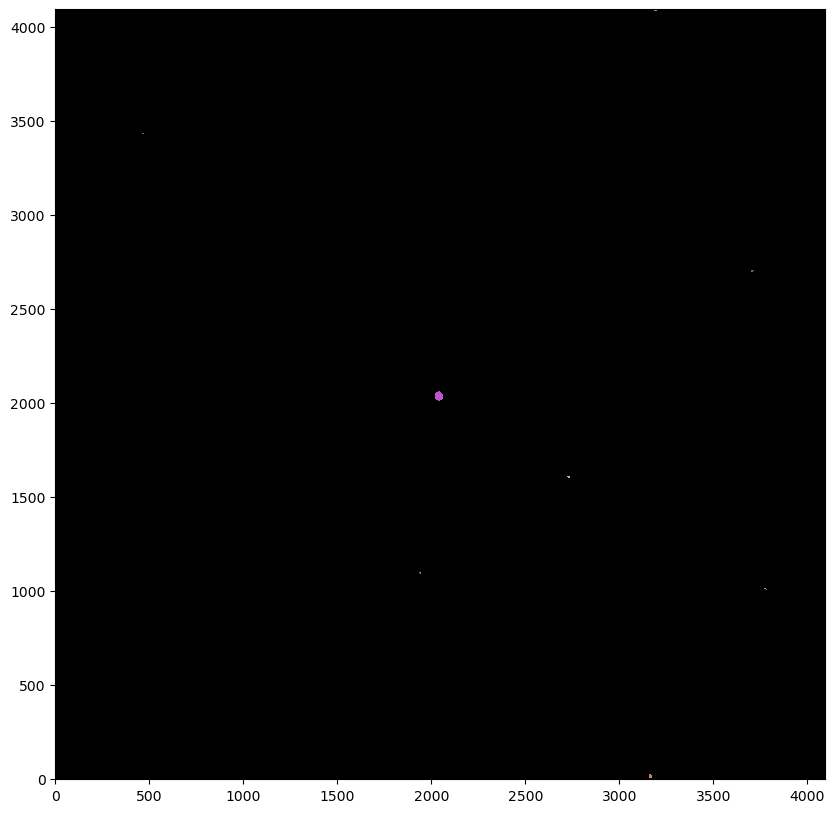

In [4]:
#Generamos un mapa de colores que asocia un color a cada fuente
cmap_sour = sour.make_cmap(seed=123)
#Mostramos las fuentes obtenidas
fig, ax = plt.subplots(1, 1, figsize=(10,10))
ax.imshow(sour, origin='lower', cmap=cmap_sour, interpolation='nearest')
plt.show()


In [5]:
#Obtenemos el catálogo
cat = SourceCatalog(data, sour)
#Lo pasamos a tabla y lo mostramos
tbl = cat.to_table()
tbl

C:\Users\aleja\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


label,xcentroid,ycentroid,sky_centroid,bbox_xmin,bbox_xmax,bbox_ymin,bbox_ymax,area,semimajor_sigma,semiminor_sigma,orientation,eccentricity,min_value,max_value,local_background,segment_flux,segment_fluxerr,kron_flux,kron_fluxerr
,,,,,,,,pix2,pix,pix,deg,,,,,,,,
int32,float64,float64,object,int32,int32,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1,3166.7081474629626,14.209945245945663,None,3157,3176,3,24,307.0,4.559406000721969,4.370575172823303,-67.52021105153923,0.2848088326717226,116.0,696.0,0.0,67027.0,nan,326945.8117169631,nan
2,3777.8464124190195,1011.3084586236401,None,3770,3784,1005,1017,118.0,3.7663641840520503,2.6963205717697623,-18.38695830453277,0.6982081502510717,116.0,230.0,0.0,16362.0,nan,264585.5364377883,nan
3,1939.9958152129318,1095.4462131779765,None,1933,1945,1089,1100,91.0,3.2697536861827414,2.5617433084125816,-6.744243573805334,0.6214337009275804,116.0,197.0,0.0,12187.0,nan,225212.95586908323,nan
4,2731.2523102075634,1607.4382996872334,None,2724,2738,1599,1614,171.0,3.6642976940307683,3.386731304210604,18.89790691022775,0.3817850686996743,116.0,354.0,0.0,28136.0,nan,314930.27252851106,nan
5,2042.0880315022428,2036.0369029672902,None,2017,2066,2011,2067,1726.0,5.613673640682258,5.405429308756714,-71.80727981167156,0.26984386853565406,116.0,31592.0,0.0,2268029.0,nan,2201873.053785172,nan
6,3709.029761448186,2703.8569456163227,None,3702,3715,2697,2709,97.0,3.2684029689087395,2.932722805249435,19.623376929974572,0.44143067888345655,116.0,219.0,0.0,13037.0,nan,252993.52125098067,nan
7,467.2183976972895,3434.9918445670423,None,463,471,3429,3440,60.0,2.8381221696186016,1.8421999076981264,74.57171214027159,0.7607106633918194,116.0,201.0,0.0,8338.0,nan,141278.06817213167,nan
8,3191.7396326073513,4092.186504421081,None,3176,3208,4083,4095,251.0,6.109110974614785,2.86909592859523,-1.7453243280858122,0.882856876212464,116.0,1578.0,0.0,59827.0,nan,224061.72079481225,nan


In [6]:
tabla = tbl['label', 'xcentroid', 'ycentroid', 'area', 'segment_flux']
tabla

label,xcentroid,ycentroid,area,segment_flux
,,,pix2,
int32,float64,float64,float64,float64
1,3166.7081474629626,14.209945245945663,307.0,67027.0
2,3777.8464124190195,1011.3084586236401,118.0,16362.0
3,1939.9958152129318,1095.4462131779765,91.0,12187.0
4,2731.2523102075634,1607.4382996872334,171.0,28136.0
5,2042.0880315022428,2036.0369029672902,1726.0,2268029.0
6,3709.029761448186,2703.8569456163227,97.0,13037.0
7,467.2183976972895,3434.9918445670423,60.0,8338.0
8,3191.7396326073513,4092.186504421081,251.0,59827.0


In [7]:
#Dividimos el "flujo" por el tiempo de exposición (para obtener de verdad el flujo xd)
tabla['segment_flux'] = tabla['segment_flux']/header['EXPTIME']
tabla

label,xcentroid,ycentroid,area,segment_flux
,,,pix2,
int32,float64,float64,float64,float64
1,3166.7081474629626,14.209945245945663,307.0,7447.444444444444
2,3777.8464124190195,1011.3084586236401,118.0,1818.0
3,1939.9958152129318,1095.4462131779765,91.0,1354.111111111111
4,2731.2523102075634,1607.4382996872334,171.0,3126.222222222222
5,2042.0880315022428,2036.0369029672902,1726.0,252003.22222222222
6,3709.029761448186,2703.8569456163227,97.0,1448.5555555555557
7,467.2183976972895,3434.9918445670423,60.0,926.4444444444445
8,3191.7396326073513,4092.186504421081,251.0,6647.444444444444


In [8]:
#Buscamos la fuente que es la estrella (mayor área)
estrella_index = np.argmax(tabla['area'])
#Obtenemos su flujo
flux_estrella = tabla['segment_flux'][estrella_index]
#Calculamos la magnitud medida
mag_1 = -2.5*np.log(flux_estrella)
#Obtenemos el zeropoint
zeropoint = 7 - mag_1
#Usamos el zeropoint para obtener la magnitud calibrada
tabla['magnitude'] = zeropoint - 2.5*np.log(tabla['segment_flux'])
tabla

label,xcentroid,ycentroid,area,segment_flux,magnitude
,,,pix2,,
int32,float64,float64,float64,float64,float64
1,3166.7081474629626,14.209945245945663,307.0,7447.444444444444,15.803927320182748
2,3777.8464124190195,1011.3084586236401,118.0,1818.0,19.32926219567627
3,1939.9958152129318,1095.4462131779765,91.0,1354.111111111111,20.065741603801623
4,2731.2523102075634,1607.4382996872334,171.0,3126.222222222222,17.974041390475833
5,2042.0880315022428,2036.0369029672902,1726.0,252003.22222222222,7.0
6,3709.029761448186,2703.8569456163227,97.0,1448.5555555555557,19.89718745670343
7,467.2183976972895,3434.9918445670423,60.0,926.4444444444445,21.014607679758523
8,3191.7396326073513,4092.186504421081,251.0,6647.444444444444,16.088023468216065


In [9]:
zeropoint

38.09299288251983